In [1]:
!pip install keras-tuner -q 

     |████████████████████████████████| 96 kB 3.7 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout,RepeatVector,TimeDistributed
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError
import keras_tuner as kt


# Load the dataset

In [3]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [5]:
#df = pd.read_csv('dataset.csv', header=None)

df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [6]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [7]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [8]:
df['Close Date'] = df['Close Date'].dt.normalize()

In [9]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [10]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [11]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [12]:
df.set_index('Close Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [13]:
columns = df.columns.tolist()
columns = columns[-1:] + columns[:-1]
df = df[columns]

In [14]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


# Split dataset into training, validation and testing datasets

#### I will now split the timeseries into training and test sets, before I scale it to prevent data leakage. https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
#### I'll be splitting the data into three sets (Training, Validation and Test)  as per the holdout method to help with determining the generalisation ability of the model during model selection. 
#### 61.45% of the data will be used for training, 12.7% will be used as the validation set and the remaining 25.85% will be used as the test set

In [16]:
split = int(len(df)*0.6145)
training_set = df[:split]      # 17/8/2017 - 31/12/2019

subset = df[split:]
split2 = int(len(subset)*0.3303)

val_set = subset[:split2]      # 1/1/2020 - 28/6/2020
test_set = subset[split2:]     # 29/6/2020 - 28/6/2021

In [17]:
print('Training: ', training_set.shape, '\nValidation: ', val_set.shape, '\nTest: ', test_set.shape)

Training:  (867, 5) 
Validation:  (180, 5) 
Test:  (365, 5)


# Split the data into X and y variables

In [18]:
# the x values will contain all the features in the dataset and the y value will contain only the target feature to predict (Close Price) 

X_training = (training_set.iloc[:, :]).values.reshape(training_set.shape[0],training_set.shape[1])
y_training = (training_set.iloc[:, 4]).values.reshape(training_set.shape[0],1)

print(X_training.shape, y_training.shape)

X_valid = (val_set.iloc[:, :]).values.reshape(val_set.shape[0],val_set.shape[1])
y_valid = (val_set.iloc[:, 4]).values.reshape(val_set.shape[0],1)

print(X_valid.shape, y_valid.shape)

X_testing = (test_set.iloc[:, :]).values.reshape(test_set.shape[0],test_set.shape[1])
y_testing = (test_set.iloc[:, 4]).values.reshape(test_set.shape[0],1)

print(X_testing.shape, y_testing.shape)

(867, 5) (867, 1)
(180, 5) (180, 1)
(365, 5) (365, 1)


# Normalisation

#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler from scikit-learn to do this.
#### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [19]:
Xscaler = MinMaxScaler(feature_range=(0,1))
yscaler = MinMaxScaler(feature_range=(0,1))

X_train = Xscaler.fit_transform(X_training)
y_train = yscaler.fit_transform(y_training)

X_val = Xscaler.fit_transform(X_valid)
y_val = yscaler.fit_transform(y_valid)

X_test = Xscaler.fit_transform(X_testing)
y_test = yscaler.fit_transform(y_testing)

## Prepare data for multi-step LSTM
##### source code: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [20]:
# stack the data horizontally

train_stacked = np.hstack((X_train, y_train))
print ("Stacked Training Data Shape: " , train_stacked.shape)

val_stacked = np.hstack((X_val, y_val))
print ("Stacked Validation Data Shape: " , val_stacked.shape)

test_stacked = np.hstack((X_test, y_test))
print ("Stacked Test Data Shape: " , test_stacked.shape)

Stacked Training Data Shape:  (867, 6)
Stacked Validation Data Shape:  (180, 6)
Stacked Test Data Shape:  (365, 6)


In [21]:
# create sequences (n_steps_in = input timesteps, n_steps_out = output timesteps)

def create_sequences(sequences, n_steps_in, n_steps_out):
 X, y = [], []

 for i in range(len(sequences)):

  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1

  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break

  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

   

In [22]:
# choose a number of time steps 
n_steps_in, n_steps_out = 7, 7

# run function
X_train, y_train = create_sequences(train_stacked, n_steps_in, n_steps_out)
print ("X train sequences: " , X_train.shape, "y train sequences" , y_train.shape)            

X_val, y_val = create_sequences(val_stacked, n_steps_in, n_steps_out)
print ("X val sequences: " , X_val.shape, "y val sequences" , y_val.shape) 

X_test, y_test = create_sequences(test_stacked, n_steps_in, n_steps_out)
print ("X test sequences: " , X_test.shape, "y test sequences" , y_test.shape)      

X train sequences:  (855, 7, 5) y train sequences (855, 7)
X val sequences:  (168, 7, 5) y val sequences (168, 7)
X test sequences:  (353, 7, 5) y test sequences (353, 7)


# Model Building on CoLab
### I will tune the model using Keras Tuner

##### https://www.danielpovey.com/files/2017_interspeech_dropout.pdf 
##### https://www.tensorflow.org/tutorials/keras/keras_tuner#define_the_model
##### https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [23]:
n_features = X_train.shape[2]

rmse = RootMeanSquaredError()
mae = MeanAbsoluteError()

# for encoder-decoder model, reshape output into [samples, timesteps, features]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

# I need to define the features during model creation so that the Keras Tuner can find the optimum values

# create Encode-Decoder LSTM model
def build_model(hp):

  model = Sequential()
  # Tuner for number of nodules/units in the model layers
  model.add(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))

  for i in range(hp.Int('n_layers', 1, 3)):  # adding variation of layers.
    model.add(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True))
    model.add(Dropout(hp.Choice('dropout', values=[0.3, 0.5, 0.7])))

  model.add(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True))
  model.add(Dropout(hp.Choice('dropout', values=[0.3, 0.5, 0.7])))
  model.add(TimeDistributed(Dense(10, activation='relu')))
  model.add(TimeDistributed(Dense(n_steps_out)))
  model.compile(loss='mse' , optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])) , metrics=[rmse, mae])

  return model


# Hypertune the model

In [24]:
# I need to set up the tuner with the correct objective function which in this case is to minimise the validation loss (i.e. the generalisation error)

tuner1 = kt.RandomSearch(build_model,
                     objective = kt.Objective("val_loss", direction="min"),
                     max_trials=10)

# Search for the best parameters

In [25]:
tuner1.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dropout (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.5, 0.7], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [26]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [27]:
# The tuner will now search across the potential values for each hyperparameter and select the best combination

tuner1.search(X_train , y_train , epochs=100 , validation_data=(X_val, y_val)  ,shuffle=False, callbacks=[stop_early])

Trial 10 Complete [00h 00m 32s]
val_loss: 0.15472620725631714

Best val_loss So Far: 0.017217475920915604
Total elapsed time: 00h 07m 53s
INFO:tensorflow:Oracle triggered exit


# Results of hypertuning

In [28]:
# This will provide a list of the top 10 best models in ascending order, with their respective parameters. 
# Model 1 at the top of the list is the optimised model that I will use for training and testing.

tuner1.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 40
n_layers: 2
dropout: 0.3
learning_rate: 0.001
Score: 0.017217475920915604
Trial summary
Hyperparameters:
units: 20
n_layers: 2
dropout: 0.3
learning_rate: 0.001
Score: 0.018303008750081062
Trial summary
Hyperparameters:
units: 70
n_layers: 2
dropout: 0.3
learning_rate: 0.001
Score: 0.020545659586787224
Trial summary
Hyperparameters:
units: 60
n_layers: 2
dropout: 0.7
learning_rate: 0.001
Score: 0.02270224690437317
Trial summary
Hyperparameters:
units: 10
n_layers: 2
dropout: 0.3
learning_rate: 0.001
Score: 0.0233148243278265
Trial summary
Hyperparameters:
units: 70
n_layers: 3
dropout: 0.3
learning_rate: 0.0001
Score: 0.026607360690832138
Trial summary
Hyperparameters:
units: 50
n_layers: 1
dropout: 0.3
learning_rate: 0.0001
Score: 0.03501038998365402
Trial summary
Hyperparameters:
units: 50
n_layers: 3
dropout: 0.5
learning_rate: 0.0

In [29]:
# best model - we still need to find the best number of epochs though
best_model_history = tuner1.get_best_models(num_models=1)[0]

In [30]:
best_model_history.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40)                7360      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 40)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 40)             12960     
_________________________________________________________________
dropout (Dropout)            (None, 7, 40)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 40)             12960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 40)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 40)             1

# Find optimal epochs by training the best model with the best hyperparameters

In [31]:
find_epoch = best_model_history.fit(X_train , y_train , epochs=100 , validation_data=(X_val, y_val) ,shuffle=False, verbose = 0)

In [32]:
val_loss_per_epoch = find_epoch.history['val_loss']    # want to find where the gap between train loss and val loss is minimal
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Best epoch: 92


# Re-train model to get final results
#### The training will be repeated 5 times for robustness
#### source code: https://github.com/yanghaocsg/keras_lstm/wiki/chapter-7.1-Evaluating-LSTM-Models-Robustly


In [33]:
best_model = tuner1.get_best_models(num_models=1)[0]

training_losses = pd.DataFrame()
validation_losses = pd.DataFrame()

training_rmse = pd.DataFrame()
validation_rmse = pd.DataFrame()

training_mae = pd.DataFrame()
validation_mae = pd.DataFrame()

for i in range(5):

  # fit model
  print('\nTraining Number ', i)
  history = best_model.fit(X_train , y_train , epochs=best_epoch , verbose=0 , validation_data=(X_val, y_val) ,shuffle=False)

  training_losses[str(i)] = history.history['loss']
  validation_losses[str(i)] = history.history['val_loss']

  training_rmse[str(i)] = history.history['root_mean_squared_error']
  validation_rmse[str(i)] = history.history['val_root_mean_squared_error']

  training_mae[str(i)] = history.history['mean_absolute_error']
  validation_mae[str(i)] = history.history['val_mean_absolute_error']


Training Number  0

Training Number  1

Training Number  2

Training Number  3

Training Number  4


In [34]:
# Retrieve results to get an average value of each

avg_trainloss_list = []
avg_valloss_list= []

avg_trainrmse_list = []
avg_valrmse_list= []

avg_trainmae_list = []
avg_valmae_list = []

for i in range(5):

  final_train_loss = training_losses.iloc[-1,i]
  final_val_loss = validation_losses.iloc[-1,i]
  avg_trainloss_list.append(final_train_loss)
  avg_valloss_list.append(final_val_loss)

  final_train_rmse = training_rmse.iloc[-1,i]
  final_val_rmse = validation_rmse.iloc[-1,i]
  avg_trainrmse_list.append(final_train_rmse)
  avg_valrmse_list.append(final_val_rmse)
  
  final_train_mae = training_mae.iloc[-1,i]
  final_val_mae = validation_mae.iloc[-1,i]
  avg_trainmae_list.append(final_train_mae)
  avg_valmae_list.append(final_val_mae)

print('Average Training Loss: ', float('%.3g' % np.mean(avg_trainloss_list)), ' ||  Average Validation Loss: ', float('%.3g' % np.mean(avg_valloss_list)))
print('Average Training RMSE: ', float('%.3g' % np.mean(avg_trainrmse_list)), ' ||  Average Validation RMSE: ', float('%.3g' % np.mean(avg_valrmse_list)))
print('Average Training MAE: ', float('%.3g' % np.mean(avg_trainmae_list)), ' ||  Average Validation MAE: ', float('%.3g' % np.mean(avg_valmae_list)))


Average Training Loss:  0.00278  ||  Average Validation Loss:  0.0137
Average Training RMSE:  0.0525  ||  Average Validation RMSE:  0.117
Average Training MAE:  0.0334  ||  Average Validation MAE:  0.0789


# Test the model on test dataset

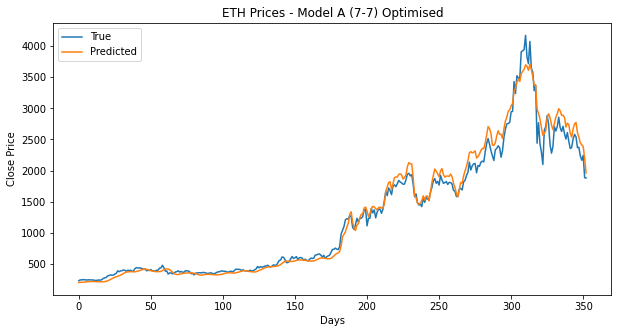


Testing Loss:  0.00294  ||  Testing RMSE:  0.0542  ||  Testing MAE:  0.0327


In [35]:
y_test_reshape = y_test.reshape((y_test.shape[0], y_test.shape[1]*y_test.shape[2]))
y_test_inv = yscaler.inverse_transform(y_test_reshape)

# generate the test predictions and plot them against the true values

test_pred = best_model.predict(X_test)
test_pred = test_pred.reshape((test_pred.shape[0], test_pred.shape[1]*test_pred.shape[2]))
test_pred = yscaler.inverse_transform(test_pred)

plt.figure(figsize = (10, 5))
plt.plot(y_test_inv[:,0], label = 'True')
plt.plot(test_pred[:,0], label = 'Predicted')
plt.legend()
plt.title('ETH Prices - Model A (7-7) Optimised')
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.show()

# generate the loss and rmse

test_loss, test_rmse, test_mae = best_model.evaluate(X_test, y_test, verbose = 0)

print('\nTesting Loss: ', float('%.3g' % test_loss), ' ||  Testing RMSE: ', float('%.3g' % test_rmse), ' ||  Testing MAE: ', float('%.3g' % test_mae))
